<a href="https://colab.research.google.com/github/alexiamhe93/RedditModerationTopicModel/blob/main/Supplementary_materials_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supplementary materials A

This Python notebook provides the materials to replicate the findings from the article titled:

*“We don't ban you immediately for an offense”: Reddit moderation and the importance of repairing norm violations for high-quality online dialogue*


--------------------------------------------
###STRUCTURE

1. Initiate notebook

In this section, we install all the necessary packages for the notebook, download and load the data, and load all the required functions for the analysis. The data consists of responses from 32 Reddit interviews on the quality of online dialogue.

2. Analysis 1: BERTopic model of Reddit moderator responses

In this section, we build a descriptive overview of moderators' responses using topic modelling (inductive).

3. Analysis 2: Conformity of deliberative model to moderator responses

In this section, we assess whether a conventional deliberative model of online dialogue quality ([Friess & Eilders, 2015](https://https://onlinelibrary.wiley.com/doi/abs/10.1002/poi3.95)) is evident in moderators' responses (deductive).

4. Analysis 3: Bad faith in moderators responses

In this section, we provide some examples of the nature of "bad faith" in moderators responses (abductive).

--------------------------------------------
###INSTRUCTIONS

Instructions for opening the notebook from a Google Drive:

1. Ensure you are logged in with a Google account
2. Click "File" -> "Copy to Drive"
3. This should open up a new Tab / Window of your browser with a copy of the notebook (saved in your Google Drive)
4. Close the original notebook

Instructions for running the notebook:
1. Run each cell individually
2. Alternatively, click "Runtime" -> "Run all"

-------------------------------------------
###IMPORTANT INFORMATION


1. Some of the code and output is embedded as a Colab text cell. This is because these require the raw text data which cannot be shared for confidentiality purposes.

2. The model and data is downloaded to the local runtime not your Google Drive itself. You can access the data on the [anonymized repository] for the article. After you disconnect the Google runtime (e.g., after you close the page) the data will be deleted.

3. The code was written with assistance from Open AI's [ChatGPT](https:///chat.openai.com) versions 3.5 and 4, used for troubleshooting and generating code for visualizations.

# 1. Initiate notebook


## 1.1 Install and load packages

In [1]:
# approximately 2 minute runtime
!pip install bertopic
!pip install openai
!pip install agreement

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 33.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 23.5 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/73

In [2]:
# Basic Python packages
import pandas as pd
# This deactivates a warning from Pandas that frequently prints
pd.options.mode.chained_assignment = None  # default='warn'
import os
import numpy as np
import random
import string
from collections import Counter

In [3]:
# BERTopic package is used for the topic modelling
from bertopic import BERTopic
from bertopic.representation import OpenAI,KeyBERTInspired
# Scikit learn used for count vectorizing (topic model) and correlations
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import pearsonr
# UMAP for reducing dimensions (topic model)
from umap import UMAP
# Gensim used for calculating coherence (topic model)
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
# Plotly for plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Natural Language ToolKit for various tasks
from nltk import agreement
# for removing stopwords and tokenizing words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 1.2 Load the data

**Note** - as the repository link has been anonymized, do not run the next cell and, instead, upload the data files and model folder to the runtime (if on Colab) or into your local directory.

In [4]:
# for downloading zip file from the article GitHub
import requests, zipfile, io
r = requests.get( 'https://github.com/alexiamhe93/RedditModerationTopicModel/blob/main/model_data.zip?raw=true' )
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [5]:
# Load dictionary data
try:
  # Topic model data
  df0 = pd.read_excel("model_data/data/SupplementaryMaterials_C1_data.xlsx", sheet_name="TopicModel_results")
  df_desc = pd.read_excel("model_data/data/SupplementaryMaterials_C1_data.xlsx", sheet_name="Mod_metadata")
  sweep_df = pd.read_excel("model_data/data/SupplementaryMaterials_C1_data.xlsx", sheet_name="TopicModel_parameterSweep")
  theme_map = pd.read_excel("model_data/data/SupplementaryMaterials_C1_data.xlsx", sheet_name="TopicModel_themeMap")
  # Inter-rater reliability data
  R1_all = pd.read_excel("model_data/data/SupplementaryMaterials_C2_data.xlsx", sheet_name="A1_Round1")
  R2_all = pd.read_excel("model_data/data/SupplementaryMaterials_C2_data.xlsx", sheet_name="A1_Round2")
  R3_all = pd.read_excel("model_data/data/SupplementaryMaterials_C2_data.xlsx", sheet_name="A1_Round3")
  AG = pd.read_excel("model_data/data/SupplementaryMaterials_C2_data.xlsx", sheet_name="A2_AG")
  HB = pd.read_excel("model_data/data/SupplementaryMaterials_C2_data.xlsx", sheet_name="A2_HB")
  MH = pd.read_excel("model_data/data/SupplementaryMaterials_C2_data.xlsx", sheet_name="A2_MH")
except:
  # Topic model data
  df0 = pd.read_excel("SupplementaryMaterials_C1_data.xlsx", sheet_name="TopicModel_results")
  df_desc = pd.read_excel("SupplementaryMaterials_C1_data.xlsx", sheet_name="Mod_metadata")
  sweep_df = pd.read_excel("SupplementaryMaterials_C1_data.xlsx", sheet_name="TopicModel_parameterSweep")
  theme_map = pd.read_excel("SupplementaryMaterials_C1_data.xlsx", sheet_name="TopicModel_themeMap")
  # Inter-rater reliability data
  R1_all = pd.read_excel("SupplementaryMaterials_C2_data.xlsx", sheet_name="A1_Round1")
  R2_all = pd.read_excel("SupplementaryMaterials_C2_data.xlsx", sheet_name="A1_Round2")
  R3_all = pd.read_excel("SupplementaryMaterials_C2_data.xlsx", sheet_name="A1_Round3")
  AG = pd.read_excel("SupplementaryMaterials_C2_data.xlsx", sheet_name="A2_AG")
  HB = pd.read_excel("SupplementaryMaterials_C2_data.xlsx", sheet_name="A2_HB")
  MH = pd.read_excel("SupplementaryMaterials_C2_data.xlsx", sheet_name="A2_MH")

This code is only here for loading the documents if required.

If uploading directly to the runtime.

```
docs = pd.read_csv("temp_doc_list.csv")
docs = docs["Text"]
```

If uploading from google drive

```
from google.colab import drive
drive.mount('/content/drive')
docs = pd.read_csv("temp_doc_list.csv")
docs = docs["Text"]
```

Descriptive statistics about the moderators:

In [6]:
df_desc.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Age,32.0,32.88,9.67,20.0,26.00,31.0,38.00,56.0
Using reddit since,32.0,2014.06,3.77,2006.0,2012.75,2014.0,2016.25,2020.0
Moderating for (years),32.0,4.98,3.39,1.0,3.00,4.0,6.25,12.0
N(subs moderating),32.0,4.19,4.53,1.0,1.00,3.0,5.00,24.0


## 1.3 Load functions

This function doesn't end up being run in this notebook (requires documents). Included here for transparency. The function is itself
adapted from code recommended in [this](https://github.com/MaartenGr/BERTopic/issues/90) StackOverflow thread. The CV metric is introduced by [Röder et al., 2015](https://dl-acm-org.gate3.library.lse.ac.uk/doi/abs/10.1145/2684822.2685324) as an advancement on existing measures.


```
# Calculates model coherence (CV) for topic model: see OCTIS for comparing topic models
def return_model_coherence(topic_model, topics, n_gram_max, docs):
  # Preprocess documents
  documents = pd.DataFrame(
      {"Document": docs,
       "ID": range(len(docs)),
       "Topic": topics}
  )
  documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
  cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)
  # Extract vectorizer and analyzer from fit model
  vectorizer_model = CountVectorizer(ngram_range=(1,n_gram_max))
  analyzer = vectorizer_model.build_analyzer()
  # Extract features for topic coherence evaluation
  tokens = [analyzer(doc) for doc in cleaned_docs]
  dictionary = corpora.Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]
  # When extracting topic words, we remove outliers
  topic_words = []
  for topic in range(len(set(topics))-topic_model._outliers):
      words = list(zip(*topic_model.get_topic(topic)))[0]
      words = [word for word in words if word in dictionary.token2id]
      topic_words.append(words)
  topic_words = [words for words in topic_words if len(words) > 0]
  coherence_cv = CoherenceModel(topics=topic_words,texts=tokens,
                                corpus=corpus,dictionary=dictionary,
                                coherence='c_v')
  C_V = coherence_cv.get_coherence()

  return C_V

```

In [7]:
def get_nTopics_outliers(topic_model):
  """
  Fetches the number of topics and outliers from the BERTopic model.
  """
  tmdf = topic_model.get_topic_info()
  nTopics = len(tmdf) - 1
  nOutliers = tmdf.iloc[0]["Count"]
  return nTopics, nOutliers

def create_output(df):
  """
  Converts df to correct format for inter-rater reliability calculation.
  """
  IRR_out = []
  for i, row in df.iterrows():
    for k in list(df.columns):
      IRR_out.append([k, str(i), row[k]])
  return IRR_out

def get_IRR(all_df):
  """
  Calculates the inter-rater reliability.
  """
  IRR_df = create_output(all_df)
  ratingtask = agreement.AnnotationTask(data=IRR_df)
  alpha = round(ratingtask.alpha(),3) # Krippendorff's Alpha
  agreement_ = round(ratingtask.avg_Ao(),3)
  return agreement_, alpha

def get_IRR2(IRR_df):
  """
  Calculates and prints the inter-rater reliability (Krippendorff's Alpha only).
  """
  ratingtask = agreement.AnnotationTask(data=IRR_df)
  print(f"Krippendorf's Alpha: {ratingtask.alpha():.2f}")
  print(f"Absolute agreement: {ratingtask.avg_Ao():.2f}")

def add_line_breaks(text, max_chars, second_linebreak_at):
  """
  Another function for adding line breaks to long texts (plotting).
  """
  if len(text) > max_chars:
      split_index1 = max_chars
      while split_index1 > 0 and text[split_index1] != ' ':
          split_index1 -= 1

      # Add a check to avoid going beyond the length of the text
      if len(text) > split_index1 + second_linebreak_at:
          split_index2 = split_index1 + second_linebreak_at
          while split_index2 > split_index1 and text[split_index2] != ' ':
              split_index2 -= 1

          return text[:split_index1] + "<br>" + text[split_index1+1:split_index2] + "<br>" + text[split_index2+1:]
      else:
          return text[:split_index1] + "<br>" + text[split_index1+1:]
  else:
      return text

# 2. Analysis 1: BERTopic model of Reddit moderator responses.

## 2.1 Model selection

In this section, we first load in data that results from using parameter sweeps to maximize the coherence of the topic model (code available upon request).

We sweeped through five hyper-parameters relating to different parts of the [BERTopic](https://maartengr.github.io/BERTopic/index.html) model pipeline (see [Grootendorst, 2022](https://arxiv.org/abs/2203.05794)). We sweep through:


> The `minimum cluster size` for input into the [HDBSCAN](https://https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) clustering algorithm.


This tells the model the minimum number of documents that can be in a cluster. The higher the number of documents, the lower the number of topics the model cal produce. As an example, let `N` is the number of documents in the dataset and `mcs` the minimum cluster size. If `mcs = N/2` where `N` then only two topics are possible in the output because the minimum cluster size is 1/2 the documents.

> The `number of components`, `nearest neighbours`, and `minimum distance` for the [UMAP](https://umap-learn.readthedocs.io/en/latest/) dimension reduction algorithm.

These modify the way UMAP reduces the dimensions for identifying higher-order relationships between the documents. Number of components determines the number of dimensions to force the data onto (e.g., 1D = a line). Nearest neighbours the way UMAP focusses on local vs global structures (e.g., smaller relationships versus bigger relationships). Minimum distance is how closely documents can be clustered together.


> The `ngram range` for the Count Vectorizer.

This determines how the topics are parsed and the representations created. If `ngram range = (1,2)`, then single words and adjacent word pairs are taken. Adjacent word triads are taken as well if `ngram range = (1,3)` and so forth.



Reports the number of parameter sweeps, the distribution of the number of outliers produced by the model, the number of topics, and the model coherence (CV; [Röder et al., 2015](https://dl-acm-org.gate3.library.lse.ac.uk/doi/10.1145/2684822.2685324)).

In [8]:
print(f"Conducted {len(sweep_df)} parameter sweeps.")
summary_stats = sweep_df.Outliers.describe()
print(f"Outliers: mean = {summary_stats['mean']:.2f}, median = {summary_stats['50%']:.2f}, SD = {summary_stats['std']:.2f}.")
summary_stats = sweep_df.nTopics.describe()
print(f"Number of topics: mean = {summary_stats['mean']:.2f}, median = {summary_stats['50%']:.2f}, SD = {summary_stats['std']:.2f}.")
summary_stats = sweep_df.CoherenceCV.describe()
print(f"Coherence CV: mean = {summary_stats['mean']:.2f}, median = {summary_stats['50%']:.2f}, SD = {summary_stats['std']:.2f}.")

Conducted 157 parameter sweeps.
Outliers: mean = 500.85, median = 475.00, SD = 159.61.
Number of topics: mean = 29.26, median = 29.00, SD = 12.67.
Coherence CV: mean = 0.75, median = 0.79, SD = 0.13.


The model coherence is overall good (Mean(CV) = 0.75, SD(CV) = O.13). Let's examine how the different hyperparameters generate higher CV values:

In [9]:
from scipy.stats import pearsonr

# CORRELATIONS WITH THE HYPERPARAMETERS
sweep_df2 = sweep_df.dropna()
correlation_1_2, p_value_1_2 = pearsonr(sweep_df2['CoherenceCV'], sweep_df2['HDBSCAN_min_cluster_size'])
correlation_1_3, p_value_1_3 = pearsonr(sweep_df2['CoherenceCV'], sweep_df2['UMAP_n_components'])
correlation_1_4, p_value_1_4 = pearsonr(sweep_df2['CoherenceCV'], sweep_df2['UMAP_n_neighbors'])
correlation_1_5, p_value_1_5 = pearsonr(sweep_df2['CoherenceCV'], sweep_df2['UMAP_min_distance'])
correlation_1_6, p_value_1_6 = pearsonr(sweep_df2['CoherenceCV'], sweep_df2['CountVec_ngram_max'])

print(f'Correlation between coherence (CV) and ngram CountVectorizer values: {correlation_1_6:.2f}, p-value: {p_value_1_6:.4f}')
print(f'Correlation between coherence (CV) and min cluster size HDBSCAN values: {correlation_1_2:.2f}, p-value: {p_value_1_2:.4f}')
print(f'Correlation between coherence (CV) and n components UMAP values: {correlation_1_3:.2f}, p-value: {p_value_1_3:.4f}')
print(f'Correlation between coherence (CV) and n neighbours UMAP values: {correlation_1_4:.2f}, p-value: {p_value_1_4:.4f}')
print(f'Correlation between coherence (CV) and min distance UMAP values: {correlation_1_5:.2f}, p-value: {p_value_1_5:.4f}')

Correlation between coherence (CV) and ngram CountVectorizer values: 0.79, p-value: 0.0000
Correlation between coherence (CV) and min cluster size HDBSCAN values: 0.17, p-value: 0.0385
Correlation between coherence (CV) and n components UMAP values: 0.03, p-value: 0.7505
Correlation between coherence (CV) and n neighbours UMAP values: -0.07, p-value: 0.3553
Correlation between coherence (CV) and min distance UMAP values: -0.09, p-value: 0.2744


In [10]:
fig_df = sweep_df

fig_df["Outlier proportion"] = fig_df.Outliers/1194 # Number of documents
fig_df = fig_df.rename(columns = {"nTopics": "Number of topics", "CoherenceCV":"CV"})

fig = make_subplots(rows=1, cols=2, subplot_titles=("Outlier Proportion vs Number of Topics", "CV vs Number of Topics"))

# Adding the first plot
fig.add_trace(
    go.Scatter(x=fig_df["Number of topics"], y=fig_df["Outlier proportion"], mode='markers', name = "Models", marker=dict(color="blue")),
    row=1, col=1
)

# Adding the second plot
fig.add_trace(
    go.Scatter(x=fig_df["Number of topics"], y=fig_df["CV"], mode='markers', marker=dict(color="blue"), showlegend=False),
    row=1, col=2
)

# Update layout
fig.update_layout(height=500, width=1200, title_text="Number of topics against Outliers and Coherence")
fig.show()

We can see that the model produces more outliers at low number of topics. This is expected as more topics means more opportunities for documents to cluster. We also see that the Coherence score also decreases relative to the number of documents. However, some models appear to perform better at larger number of topics in the model.

This graph shows all the models in a line graph:

In [11]:
sweep_df["Outlier proportion"] = sweep_df.Outliers/1194 # number of documents
hPdf  = sweep_df[['CoherenceCV','nTopics','Outliers', 'Outlier proportion', 'UMAP_n_neighbors', 'UMAP_min_distance', 'UMAP_n_components','CountVec_ngram_max', 'HDBSCAN_min_cluster_size']]
hPdf = hPdf.rename(columns = {"UMAP_n_neighbors": "n Neighbours (UMAP)",
                              "UMAP_min_distance": "min Distance (UMAP)",
                              "UMAP_n_components": "n Components (UMAP)",
                              "CountVec_ngram_max": "max ngram (CountVectorizer)",
                              "HDBSCAN_min_cluster_size": "min Cluster Size (HDBSCAN)",
                              "CoherenceCV": "CV (Coherence)",
                              "nTopics": "n Topics",
                              "Outliers": "n Outliers"})
hPdf = hPdf.sort_values("CV (Coherence)", ascending = False).round(2)
fig = px.parallel_coordinates(hPdf, color = "max ngram (CountVectorizer)",
                              dimensions=['n Neighbours (UMAP)', 'min Distance (UMAP)', 'n Components (UMAP)',
                                          'min Cluster Size (HDBSCAN)',"n Topics", "CV (Coherence)"],
                              #color_continuous_scale=px.colors.diverging.Tealrose,
                              #color_continuous_midpoint=2
                              )
fig.show()

What this graph shows is that the minimum cluster size has the largest effect on the overall coherence, however that the number of components appears to also generate higher cluster sizes. Let's see which is the best model:

In [12]:
hPdf.head(5)

,CV (Coherence),n Topics,n Outliers,Outlier proportion,n Neighbours (UMAP),min Distance (UMAP),n Components (UMAP),max ngram (CountVectorizer),min Cluster Size (HDBSCAN)
2,0.92,1.0,1180.0,0.99,10,0.10,2,3,7
60,0.91,25.0,519.0,0.43,10,0.00,4,3,9
74,0.90,15.0,515.0,0.43,15,0.01,5,3,15
57,0.90,11.0,526.0,0.44,10,0.00,4,3,20
58,0.90,12.0,443.0,0.37,10,0.00,4,3,15


We observe how our best model has only one topic (it failed to converge) but our second best has 25 topics (CV = 0.91). The top five all have slightly different hyperparameters. For our final model, we went with the second model listed above and its hyperparameters.

## 2.2. Load saved topic model

**NOTE** This code trained the topic model. Every run of the topic model is different. Therefore, we have opted to save a version of the model to assess the results.

The original code used for running the final model:
````
rep_KeyBert = KeyBERTInspired(random_state=42)
rep_GPT = OpenAI(model="gpt-3.5-turbo", delay_in_seconds=5, chat=True)

# Set hyper-parameters
representations = {"Main":[],
                   "Aspect1":[rep_KeyBert, rep_GPT],
                   "Aspect2":rep_KeyBert}

umap_model = UMAP(n_neighbors = 10,
                          n_components=4,
                          min_dist = 0.0,
                          low_memory=True)

topic_model = BERTopic(embedding_model = 'all-mpnet-base-v2',
                       umap_model=umap_model,
                       min_topic_size = 9,
                       calculate_probabilities = True,
                       n_gram_range = (1,3),
                       representation_model = representations)

topics, probs = topic_model.fit_transform(docs)

# Reduce outliers using the `probabilities` strategy
new_topics = topic_model.reduce_outliers(docs, topics, probabilities=probs, strategy="probabilities")
`````


If you do want to run your own model, we recommend changing the runtime to a GPU (T4 is fine) as this considerably speeds up the BERTopic model inferences. Check to see if you are using a GPU by running the below code:

In [13]:
# Check the gpu is active
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


Load in our final and previously trained model:

In [14]:
topic_model = BERTopic.load("model_data/model")
topics = topic_model.topics_
topic_df = topic_model.get_topic_info()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Rename the topic names according to the manually decided theme names.

In [15]:
new_labels = theme_map.sort_values("Topic")["New Name"].to_list()
new_names = [[i] for i in new_labels]
topicNames = dict(zip(topic_df.Topic.to_list(), new_labels))
topic_model.set_topic_labels(topicNames)

Examine the model results:

**NOTE:** This code has been removed from the final notebook as it requires the documents to run.

Input:
```
CV = return_model_coherence(topic_model,topics, 3, docs)
print(f"Coherence CV: {round(CV,2)}")
nTop, nOut = get_nTopics_outliers(topic_model)
print(f"Produces {nTop} topics with {nOut}({round(nOut/len(docs)*100,2)}%) outliers")
```
Output:

Coherence CV: 0.89

Produces 26 topics with 526(44.05%) outliers


## 2.3. Topic model results



In [16]:
topic_model.visualize_hierarchy(custom_labels=True)

In [17]:
topic_model.visualize_topics(custom_labels=True)

This plot requires the documents, hence, it is embedded rather than run in the notebook.

```
topic_model.visualize_documents(docs, hide_document_hover=True, hide_annotations = True, custom_labels = True)
```

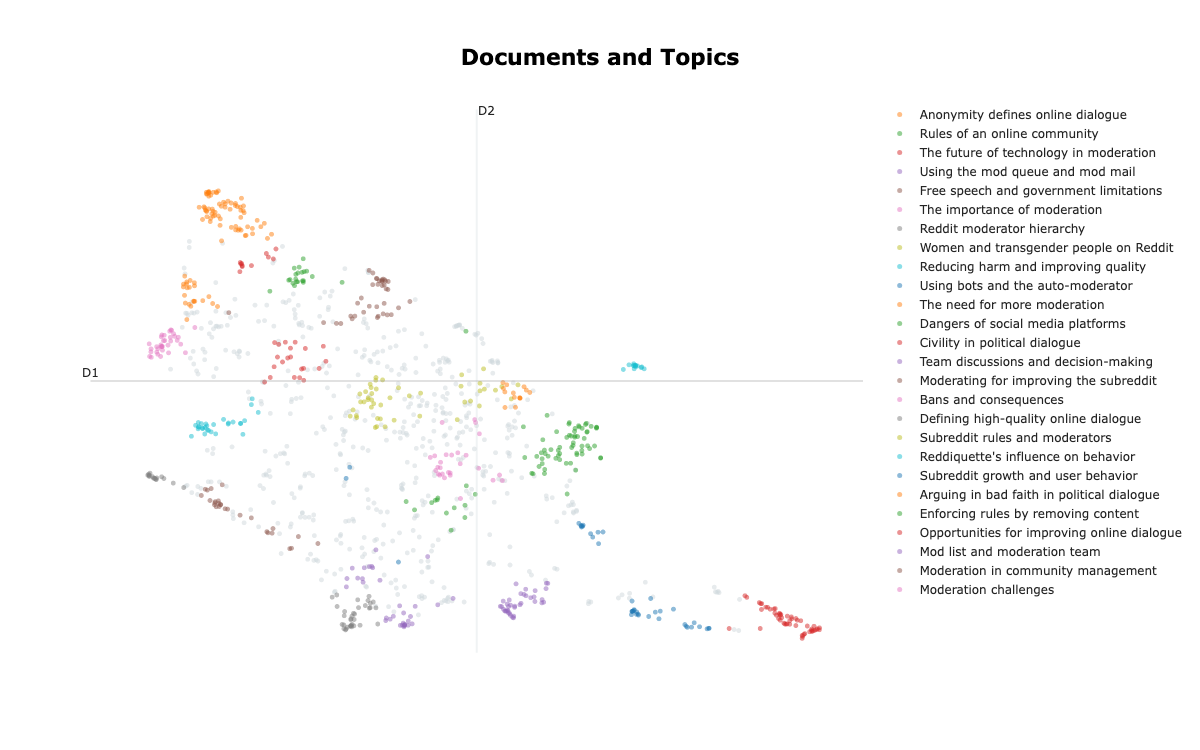

NOTE:
The names of the different topics are derived by

1. Feeding the words and representative documents for each topic to OpenAI's GPT-3.5-Turbo model
2. Manual examination of topics and editing of title.

See "theme_map.csv" for the original GPT-3.5-Turbo topic names.

## 2.4 Organize and rename topics into a hierarchy.

First we calculate the inter-rater reliability to see how well the coders and topic model (indicated as the suffix "_TM") agree.

In [21]:
# Create new theme/topic name mapping dictionaries
topic_name = dict(zip(theme_map.Topic,theme_map["Topic Name"]))
theme_numerical = dict(zip(theme_map.Topic,theme_map.Themes))
theme_name = dict(zip(theme_map.Topic,theme_map["Theme code"]))

# Get the list of outliers
outlier_list = df0[df0.Topics_first == -1].Turn.values
R1_all = R1_all.rename(columns={1:"Turn"})
# If wanting to remove outliers
R1_all_2 = R1_all[~R1_all.Turn.isin(outlier_list)]
R2_all_2 = R2_all[~R2_all.Turn.isin(outlier_list)]
R3_all_2 = R3_all[~R3_all.Turn.isin(outlier_list)]

# Looking at the hierarchical split
replace_dict = {'Rules': "processes",
                'Managerial': "processes",
                'Operational': "processes",
                'Norms': "reasons",
                'Motivations': "reasons",
                'Affordances': "reasons"}

# With outliers
R1_all_H = R1_all.replace(replace_dict)
R2_all_H = R2_all.replace(replace_dict)
R3_all_H = R3_all.replace(replace_dict)

# Without outliers
R1_all_2H = R1_all_2.replace(replace_dict)
R2_all_2H = R2_all_2.replace(replace_dict)
R3_all_2H = R3_all_2.replace(replace_dict)

# Get all the IRR results
R1_agreement, R1_alpha = get_IRR(R1_all[["Theme_TM","Theme_AG","Theme_HB","Theme_MH"]])
R1_agOut, R1_alOut = get_IRR(R1_all_2[["Theme_TM","Theme_AG","Theme_HB","Theme_MH"]])
R2_ag, R2_al = get_IRR(R2_all[["Theme_TM","Theme_AG","Theme_HB","Theme_MH"]])
R2_agOut, R2_alOut = get_IRR(R2_all_2[["Theme_TM","Theme_AG","Theme_HB","Theme_MH"]])
R3_ag, R3_al = get_IRR(R3_all[["Theme_TM","Theme_AG"]])
R3_agOut, R3_alOut = get_IRR(R3_all_2[["Theme_TM","Theme_AG"]])

R1H_ag, R1H_al = get_IRR(R1_all_H[["Theme_TM","Theme_AG","Theme_HB","Theme_MH"]])
R1H_agOut, R1H_alOut = get_IRR(R1_all_2H[["Theme_TM","Theme_AG","Theme_HB","Theme_MH"]])
R2H_ag, R2H_al = get_IRR(R2_all_H[["Theme_TM","Theme_AG","Theme_HB","Theme_MH"]])
R2H_agOut, R2H_alOut = get_IRR(R2_all_2H[["Theme_TM","Theme_AG","Theme_HB","Theme_MH"]])
R3H_ag, R3H_al = get_IRR(R3_all_H[["Theme_TM","Theme_AG"]])
R3H_agOut, R3H_alOut = get_IRR(R3_all_2H[["Theme_TM","Theme_AG"]])

# Create output dataframes
agreement_rounds = [R1_agreement,R2_ag,R3_ag]
agOut_rounds = [R1_agOut,R2_agOut,R3_agOut]
agH_rounds = [R1H_ag,R2H_ag,R3H_ag]
agHOut_rounds = [R1H_agOut,R2H_agOut,R3H_agOut]

alpha_rounds = [R1_alpha,R2_al,R3_al]
alOut_rounds = [R1_alOut,R2_alOut,R3_alOut]
alH_rounds = [R1H_al,R2H_al,R3H_al]
alHOut_rounds = [R1H_alOut,R2H_alOut,R3H_alOut]

rows = ["Round 1", "Round 2", "Round 3"]
Irr_results = {"Round":rows,"Agreement (all)":agreement_rounds, "Alpha (all)":alpha_rounds,
            "Agreement (Outlier removed)": agOut_rounds, "Alpha (Outlier removed)": alOut_rounds}

Irr_Hresults = {"Round":rows,"Agreement (all)":agH_rounds, "Alpha (all)":alH_rounds,
            "Agreement (Outlier removed)": agHOut_rounds, "Alpha (Outlier removed)": alHOut_rounds}

# Create MultiIndex for columns
columns = pd.MultiIndex.from_tuples([
    ('Round', ''),('With Outliers', 'Agreement'),
     ('With Outliers', 'Alpha'),('Removed Outliers', 'Agreement'),('Removed Outliers', 'Alpha')])

Irr_result_df = pd.DataFrame(Irr_results)
Irr_result_df.columns = columns

Irr_H_result_df = pd.DataFrame(Irr_Hresults)
Irr_H_result_df.columns = columns

## 2.5 Inter-rater reliability


### 2.5.1 IRR at the theme level

In [22]:
Irr_result_df

Round With Outliers        Removed Outliers       
               Agreement  Alpha        Agreement  Alpha
0  Round 1         0.648  0.582            0.737  0.685
1  Round 2         0.641  0.572            0.688  0.629
2  Round 3         0.533  0.425            0.708  0.640

### 2.5.2 IRR at the hierarchy level

In [24]:
Irr_H_result_df

Round With Outliers        Removed Outliers       
               Agreement  Alpha        Agreement  Alpha
0  Round 1         0.830  0.683            0.885  0.776
1  Round 2         0.812  0.648            0.849  0.716
2  Round 3         0.824  0.650            0.896  0.793

We can see that coders agree more on the organization of the topics than on the theme level organization. Furthermore, removing outliers greatly increases the scores, again indicating that the topic model is coherent (human coders also agree on the outlier documents).

In [23]:
topicTheme_map1 = dict(zip(theme_map["Topic Name"],theme_map["Theme code"]))
Speaker_topic_df = df0[["Turn", "Speaker", "Topics_wOutliers_GPT"]]
Speaker_topic_df = Speaker_topic_df.rename(columns={"Topics_wOutliers_GPT": "Topics"})

We now can observe the different themes present in the responses. The below shows that moderators mostly talk about their managerial processes, followed by their motivations for moderation. Moderators talk less about norms and rules than other topics.

In [25]:
# Looking at the hierarchical split
replace_dict = {'Rules': "processes",
                'Managerial': "processes",
                'Operational': "processes",
                'Norms': "reasons",
                'Motivations': "reasons",
                'Affordances': "reasons"}

Speaker_topic_df["Themes"] = Speaker_topic_df["Topics"].replace(topicTheme_map1)

Speaker_topic_df["Hierarchy"] = Speaker_topic_df["Themes"].replace(replace_dict)

grouped_df_H = pd.DataFrame(Speaker_topic_df.groupby("Hierarchy").Themes.value_counts()).rename(columns={"Themes":"Count"}).reset_index()
grouped_df_H["Pct"] = round(grouped_df_H["Count"]/len(Speaker_topic_df),2)
grouped_df_H.sort_values("Count", ascending = False)

,Hierarchy,Themes,Count,Pct
0,processes,Managerial,276,0.23
3,reasons,Motivations,250,0.21
4,reasons,Affordances,207,0.17
1,processes,Operational,176,0.15
2,processes,Rules,157,0.13
5,reasons,Norms,128,0.11


# 3. Analysis 2: Conformity of deliberative model to moderator responses


In [26]:
# Your existing code for data preparation
high_irr = "Deviates (Agree)"
low_irr = "Deviates (Disagree)"
low_rel = "Conforms (Disagree)"
high_rel = 'Conforms (Agree)'

color_map = {high_rel: '#5DADE2',
             low_rel :  "#D6EAF8", #"#AED6F1",
             low_irr : "#FCF3CF", #"#F9E79F",
             high_irr : '#F4D03F'}

def col_mapper(val):
  if val == 1:
    return high_rel
  elif val == 0.5:
    return low_rel
  elif val == -0.5:
    return low_irr
  elif val == -1:
    return high_irr

## 3.1 Calculate inter-rater reliability between coders

We see a low inter-rater reliability as the coders could not fully agree on the appropriate relevance of the dimensions to the categories.

In [27]:
Target_cols = ["Rationality", "Interactivity", "Equality", "Civility", "Constructiveness", "Common good reference"]
Value_replace = {'Irrelevant':1, 'Relevant': 2}
outdfs_IRR_nltk = []
for col in Target_cols:
  AG_temp = AG[["Topic",col]].rename(columns = {col:"AG"})
  HB_temp = HB[["Topic",col]].rename(columns = {col:"HB"})
  MH_temp = MH[["Topic",col]].rename(columns = {col:"MH"})
  temp_IRR = AG_temp.merge(MH_temp, on="Topic", how="outer")
  temp_IRR = temp_IRR.merge(HB_temp, on="Topic", how="outer")
  temp_IRR = temp_IRR[["AG","HB","MH"]]
  temp_IRR = temp_IRR.fillna("Irrelevant")
  temp_IRR4 = create_output(temp_IRR)
  outdfs_IRR_nltk.append(temp_IRR4)

In [28]:
for i in range(0,len(Target_cols)):
  dim = Target_cols[i]
  print(f"\n--------------\n{dim}:")
  get_IRR2(outdfs_IRR_nltk[i])


--------------
Rationality:
Krippendorf's Alpha: 0.60
Absolute agreement: 0.79

--------------
Interactivity:
Krippendorf's Alpha: 0.18
Absolute agreement: 0.59

--------------
Equality:
Krippendorf's Alpha: 0.10
Absolute agreement: 0.72

--------------
Civility:
Krippendorf's Alpha: 0.47
Absolute agreement: 0.77

--------------
Constructiveness:
Krippendorf's Alpha: 0.14
Absolute agreement: 0.56

--------------
Common good reference:
Krippendorf's Alpha: 0.17
Absolute agreement: 0.59


## 3.2 Examining the agreement between the coders

Let's delve a bit deeper into the disagreements. We can see from the IRR that rationality has decent IRR. If we now visualize the results, we can see more clearly which topic is doing what.


In [29]:
outdfs_reflection = []
for col in Target_cols:
  AG_temp = AG[["Topic Name",col]].rename(columns = {col:"AG"})
  HB_temp = HB[["Topic Name",col]].rename(columns = {col:"HB"})
  MH_temp = MH[["Topic Name",col]].rename(columns = {col:"MH"})
  temp_IRR = AG_temp.merge(MH_temp, on="Topic Name", how="outer")
  temp_IRR = temp_IRR.merge(HB_temp, on="Topic Name", how="outer")
  temp_IRR = temp_IRR.fillna("Irrelevant")
  outdfs_reflection.append(temp_IRR)

Topic_df2 = AG[["Topic Name"]]
rep_dict_names = dict(zip(theme_map["Topic Name"].to_list(), theme_map["New Name"]))
Topic_df2["Topic Name"] = Topic_df2["Topic Name"].replace(rep_dict_names)

def decide_lvl2(list_of_relevance):
  list_of_relevance = [0 if val == "Irrelevant" else 1 for val in list_of_relevance]
  return sum(list_of_relevance)/3

for col in Target_cols:
  temp_col = []
  temp_AG = AG[col].to_list()
  temp_MH = MH[col].to_list()
  temp_HB = HB[col].to_list()
  for i in range(0, len(temp_AG)):
    vals = [temp_AG[i],temp_MH[i], temp_HB[i]]
    level = round(decide_lvl2(vals),2)
    temp_col.append(level)
  Topic_df2[col] = temp_col
all_col = []
for i, row in Topic_df2.iterrows():
  temp_vals = []
  for col in Target_cols:
    temp_vals.append(row[col])
  score = round((sum(temp_vals)/6),2)
  all_col.append(score)
Topic_df2["Score"] = all_col
Topic_df2 = Topic_df2.sort_values("Score", ascending = False)

Target_cols2 = ["Rationality", "Interactivity", "Equality", "Civility", "Constructive", "Common good"]

Topic_df2_conf = Topic_df2.sort_values("Score",ascending=False)
Topic_df2_conf = Topic_df2_conf.drop("Score", axis = 1)
Topic_df2_conf = Topic_df2_conf.replace({0:-1, 0.33:-0.5, 0.67:0.5})
Topic_df2_conf = Topic_df2_conf.rename(columns={"Common good reference": "Common good",
                                                "Constructiveness": "Constructive"})
topics,dimensions,relevance = [],[],[]
for i, row in Topic_df2_conf.iterrows():
  for col in Target_cols2:
    topics.append(row["Topic Name"])
    dimensions.append(col)
    relevance.append(row[col])
long_topicDf = pd.DataFrame({"topics":topics,"dimensions":dimensions,"relevance":relevance})
long_topicDf = long_topicDf.sort_values("relevance")

# Add a new column for color based on the Value
long_topicDf['Confidence'] = long_topicDf['relevance'].apply(lambda x: col_mapper(x))
long_topicDf["relevance"] = long_topicDf["relevance"].replace({-0.5:-1,0.5:1})
facet_order = ["Civility", "Constructive","Rationality","Interactivity", "Common good", "Equality" ]

In [30]:
# Change relevance so that we can create a matrix like graph
long_topicDf["relevance2"] = long_topicDf["relevance"].replace({-1:1})

global_font_size = 14
title_font = 14

max_char = 23  # Maximum words before adding a line break
second_linebreak_at = max_char

# Create a divergent bar chart using Plotly Express
fig = px.bar(
    long_topicDf,
    y='topics',
    x='relevance2',
    color = "Confidence",
    color_discrete_map=color_map,
    facet_col='dimensions',  # Use 'relative' for stacked bars
    category_orders={'dimensions': facet_order},
    labels={'relevance2': 'Conformity'}
)

fig.update_yaxes(
    title_text='',
    ticktext=[add_line_breaks(text, max_char, second_linebreak_at) for text in long_topicDf['topics']],
    tickvals=long_topicDf['topics'],
    tickmode='array',  # Use array mode for custom tick placement
    tick0=0.5,  # Starting point for the ticks
    dtick=1.5,  # Adjust the interval between ticks as needed

)

fig.update_xaxes(
    title_text=''
)

fig.update_layout(height=1400, width = 1000)
fig.update_layout(
    plot_bgcolor='white',  # Set background color to transparent
    paper_bgcolor='white',
    yaxis=dict(
        categoryorder='array',
        categoryarray=list(reversed(long_topicDf['topics'])),
        tickfont=dict(size=global_font_size,family="Arial")
    )
)

fig.update_layout(legend=dict(
    title = "Conformity",
    orientation= 'h',
    yanchor="bottom",
    y=-0.03,
    xanchor="left",
    x=-0.01,
    font_size=11,
    #font=dict(family="Arial Black")

))

fig.update_annotations(font_size=global_font_size, font=dict(family="Arial"))
# add X-axis title
fig.add_annotation(
    showarrow=False,
    xanchor='center',
    yanchor = "top",
    xref="paper", yref="paper",
    #x= 0.5,
    y=1.05,
    text='Deliberative dimensions',
    font_size=title_font, font=dict(family="Arial Black")
)
fig.for_each_xaxis(lambda axis: axis.update(
    tickmode='array',
    tickvals=[-1, 1],
    ticktext=["",""],
    zeroline = True,
    showgrid=True, gridwidth=1, gridcolor='lightgrey',
))

fig.for_each_annotation(lambda a: a.update(
    text=a.text.split("=")[-1],
    x=a.x - 0.01 if a.x is not None else None))

fig.show()

We can see that four columns have very little conformity to the quality dimensions of online dialogue. That said, rationality and civility both appear consistently across topics, indicating moderators were systematically speaking about dialogue quality in relation to these dimensions.

A key surprise is that moderators speech is so consistently considered unconforming to the equality dimension.

# Analysis 3: Bad faith

**NOTE** This whole section is not runnable in this notebook. Code and outputs are all embedded in the text.

_________________________________________

FUNCTIONS

```

def get_ngram_counts(corpus, n):
  """
  Function to extract n-grams from a text
  """
  vectorizer = CountVectorizer(ngram_range=(n, n))
  ngrams_matrix = vectorizer.fit_transform(corpus)
  ngram_counts = ngrams_matrix.sum(axis=0).A1
  feature_names = vectorizer.get_feature_names_out()
  ngram_df = pd.DataFrame({'ngram': feature_names, 'count': ngram_counts})
  return ngram_df

def remove_stopwords(text):
  """
  Function for removing stopwords
  """
  words = word_tokenize(text)
  filtered_words = [word for word in words if word.lower() not in custom_stopwords]
  return ' '.join(filtered_words)

def clean_text(text):
  """
  Function to remove punctuation and double spaces also duplicated sequenced words (e.g., "hi hi")
  """
  text = text.lower()
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = ' '.join(text.split())
  words = text.split()
  cleaned_words = [words[i] for i in range(len(words)) if i == 0 or words[i] != words[i-1]]
  cleaned_words = [word for word in cleaned_words if not word.isdigit()]
  cleaned_text = ' '.join(cleaned_words)
  return cleaned_text
```
__________________________________
CODE AND OUTPUTS:

First we remove stopwords and keep only content words. We will look at common bigrams in the data:

```
len(set(stopwords.words('english')))
# Customize the stopwords list
custom_stopwords = set(stopwords.words('english')).union({'nt', 're',"s", "like","know","yeah","think", "gon", "na",
                                                         "would", "say", "little", "bit", "lot", "make", "sure",
                                                          "one", "thing","things","get","really","kind","want","something",
                                                          "see","going","go", "sort", "well","way","probably",
                                                          "need", "moderation","online", "pretty", "much", "come",
                                                          "every","single", "mod","mail","queue","even","though",
                                                          "moderator","auto","january", "6th", "oh", "god", "time","zone", "whole", "bunch", "take", "look"})

df0["Text"] = docs
df0["Text_no_stop"] = df0["Text"].apply(lambda x: remove_stopwords(x))
df0['Text_no_stop'] = df0['Text_no_stop'].apply(clean_text)
df0["Text_no_stop"] = df0["Text_no_stop"].apply(lambda x: remove_stopwords(x))
all_unigrams = get_ngram_counts(df0["Text_no_stop"],2)
all_unigrams.sort_values("count", ascending=False).head(10)
```

OUTPUT

| ngram         | count |
|---------------|-------|
| free speech   | 115   |
| real life     | 56    |
| high quality  | 39    |
| good faith    | 37    |
| hate speech   | 31    |
| bad faith     | 31    |
| united states | 30    |
| someone else  | 27    |
| people post   | 26    |
| years ago     | 26    |

Perhaps unsurprisingly, the term "free speech" dominates the data. However, we also see the terms "good faith" and "bad faith" appear frequently. Combined, moderators are speaking more about good faith and bad faith (n = 76) than they mention hate speech (n = 31).
(This is an imprecise way of estimating mentions of hate speech (other terms e.g., incivility might also be used to mean hate speech)).

Moderators frequently discussed user intentions in terms of good faith and bad faith:

```
bad_faith_dict = ["bad faith",  "bad people", "bad actor", "bad person", "ill intentions", "mean people", "purposefully misunderstands",
                  "ulterior motive","intentionally harmful", "hateful people",  "disingenuous", "specific agenda", "troll"]
good_faith_dict = ["good faith", "good people", "wellmeaning","wellintended", "being genuine"]


all_faith = bad_faith_dict + good_faith_dict

all_faith_df = df0[df0['Text'].str.contains('|'.join(all_faith), case=False)]
all_faith_df1 = df0[df0['Text_no_stop'].str.contains('|'.join(all_faith), case=False)]
allF_df = pd.concat([all_faith_df, all_faith_df1])
n_mentioning_bad_faith = len(allF_df.drop_duplicates().Speaker.unique())
n_mbf_pct = n_mentioning_bad_faith / 32 * 100
print(f"{n_mentioning_bad_faith} moderators ({n_mbf_pct:.2f}%) mention good or bad faith.")
```

OUTPUT:

27 moderators (84.38%) mention good or bad faith.

```
bf = df0[df0['Text'].str.contains('|'.join(["bad faith",  "good faith"]), case=False)]
bf1 = df0[df0['Text_no_stop'].str.contains('|'.join(["bad faith",  "good faith"]), case=False)]
bf_ = pd.concat([bf, bf1])
n_mentioning_bad_faith = len(bf_.drop_duplicates().Speaker.unique())
n_mbf_pct = n_mentioning_bad_faith / 32 * 100
print(f"{n_mentioning_bad_faith} moderators ({n_mbf_pct:.2f}%) mention good or bad faith explicitly.")
```

12 moderators (37.50%) mention good or bad faith explicitly.


## 3.1 Quotes on bad faith / good faith

```
bf_["Text"].values[9]
```

"But even then, like, there's so many nuances to online discussion. Because you cannot see or hear or interact with personally the person on the other side of that comment, which makes, which forces moderators into the position of, I have to assume bad faith first, which sucks. Because I would love to assume good faith. But I know from previous interactions with people like that, 50% of the time it is bad faith. And then 40% of the time it is completely ignorant without, like, without any, how do I put this, like resolve to change. And then 10% of the time is like a good faith question with like good faith replies. And they literally just didn't understand something. And now they do. For the most part, I've seen that other 90% where they're either a troll or they're ignorant on purpose. Like, I hate to be that way, but like, you know, you explain something and you explain it very well. And they then ask a follow up question as if they did not read your comment, then it's like, I can't tell if this is a troll or if they're being ignorant. So, you know, you gotta, we had to moderate based on the fact that most likely they're a troll."

```
bf_["Text"].values[20]
```

"And one of the biggest complaints that we would get is that, you know, oh, no, it's all of the people from our politics are coming in and they're ruining the discussion. And I understand that point of view from our regular users. But at the same time, I, you know, as far as getting our ideas out there, I tend to think if you build a community where that good faith discussion can happen, if you build it, they will come. And besides, if they're just a dumb head, you can ban them. I mean, if somebody is legitimately not willing to engage in a conversation, then, yeah, you can just ban them. But luckily, I don't, that doesn't normally happen. I think one of the nice things with as many moderators as we have, it's easy, it's very difficult for users to just point at like one person and say, you know, you're a dictatorship. You can always appeal a ban. You like multiple, there are many ways to go about it. But if you really think that you are acting in good faith, you can make your case. We would never shut, we don't shut people. I mean, unless you're like sexist or racist or whatever, get out. But for the most part, it's, yeah, so."